In [50]:
import cv2
from cv2 import aruco
from datetime import datetime
from loguru import logger
from pathlib import Path
from typing import cast, Final, TypeAlias
from cv2.typing import MatLike
from matplotlib import pyplot as plt
import numpy as np

NDArray: TypeAlias = np.ndarray

In [51]:
INPUT_IMAGE = Path("merged_uv_layout.png")
# 7x7
DICTIONARY: Final[int] = aruco.DICT_7X7_1000
# 400mm
MARKER_LENGTH: Final[float] = 0.4

In [52]:
aruco_dict = aruco.getPredefinedDictionary(DICTIONARY)
detector = aruco.ArucoDetector(
    dictionary=aruco_dict, detectorParams=aruco.DetectorParameters()
)

In [53]:
frame = cv2.imread(str(INPUT_IMAGE))
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# pylint: disable-next=unpacking-non-sequence
markers, ids, rejected = detector.detectMarkers(grey)

In [54]:
# Note: BGR
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)
GREY = (128, 128, 128)
CYAN = (255, 255, 0)
MAGENTA = (255, 0, 255)
ORANGE = (0, 165, 255)
PINK = (147, 20, 255)

UI_SCALE = 10
UI_SCALE_FONT = 8
UI_SCALE_FONT_WEIGHT = 20

In [55]:
out = frame.copy()
# `markers` is [N, 1, 4, 2]
# `ids` is [N, 1]
if ids is not None:
    markers = np.reshape(markers, (-1, 4, 2))
    ids = np.reshape(ids, (-1, 1))
    # logger.info("markers={}, ids={}", np.array(markers).shape, np.array(ids).shape)
    for m, i in zip(markers, ids):
        # logger.info("id={}, center={}", i, center)
        center = np.mean(m, axis=0).astype(int) # type: ignore
        # BGR
        color_map = [RED, GREEN, BLUE, YELLOW]
        for color, corners in zip(color_map, m):
            corners = corners.astype(int)
            out = cv2.circle(out, corners, 5*UI_SCALE, color, -1)
        cv2.circle(out, tuple(center), 5*UI_SCALE, CYAN, -1)
        cv2.putText(
            out,
            str(i),
            tuple(center),
            cv2.FONT_HERSHEY_SIMPLEX,
            1*UI_SCALE_FONT,
            MAGENTA,
            UI_SCALE_FONT_WEIGHT,
        )

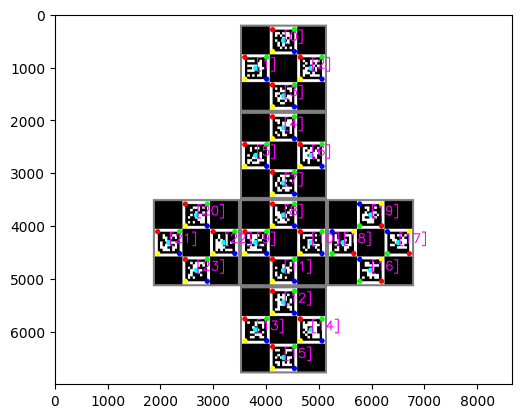

In [56]:
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

In [57]:
cv2.imwrite("merged_uv_layout_with_markers.png", out)

True